<a href="https://colab.research.google.com/github/LiYuan199701/TimeSeries/blob/single-perceptron-TS/Single_Neuron_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Perceptron Simulation for time series

In [39]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

plt.rcParams['figure.dpi'] = 130  # Adjust for inline display resolution
plt.rcParams['savefig.dpi'] = 130 # Adjust for saved figure resolution

# Generate Simlulation time series

Text(0.5, 1.0, 'Bounded Time Series')

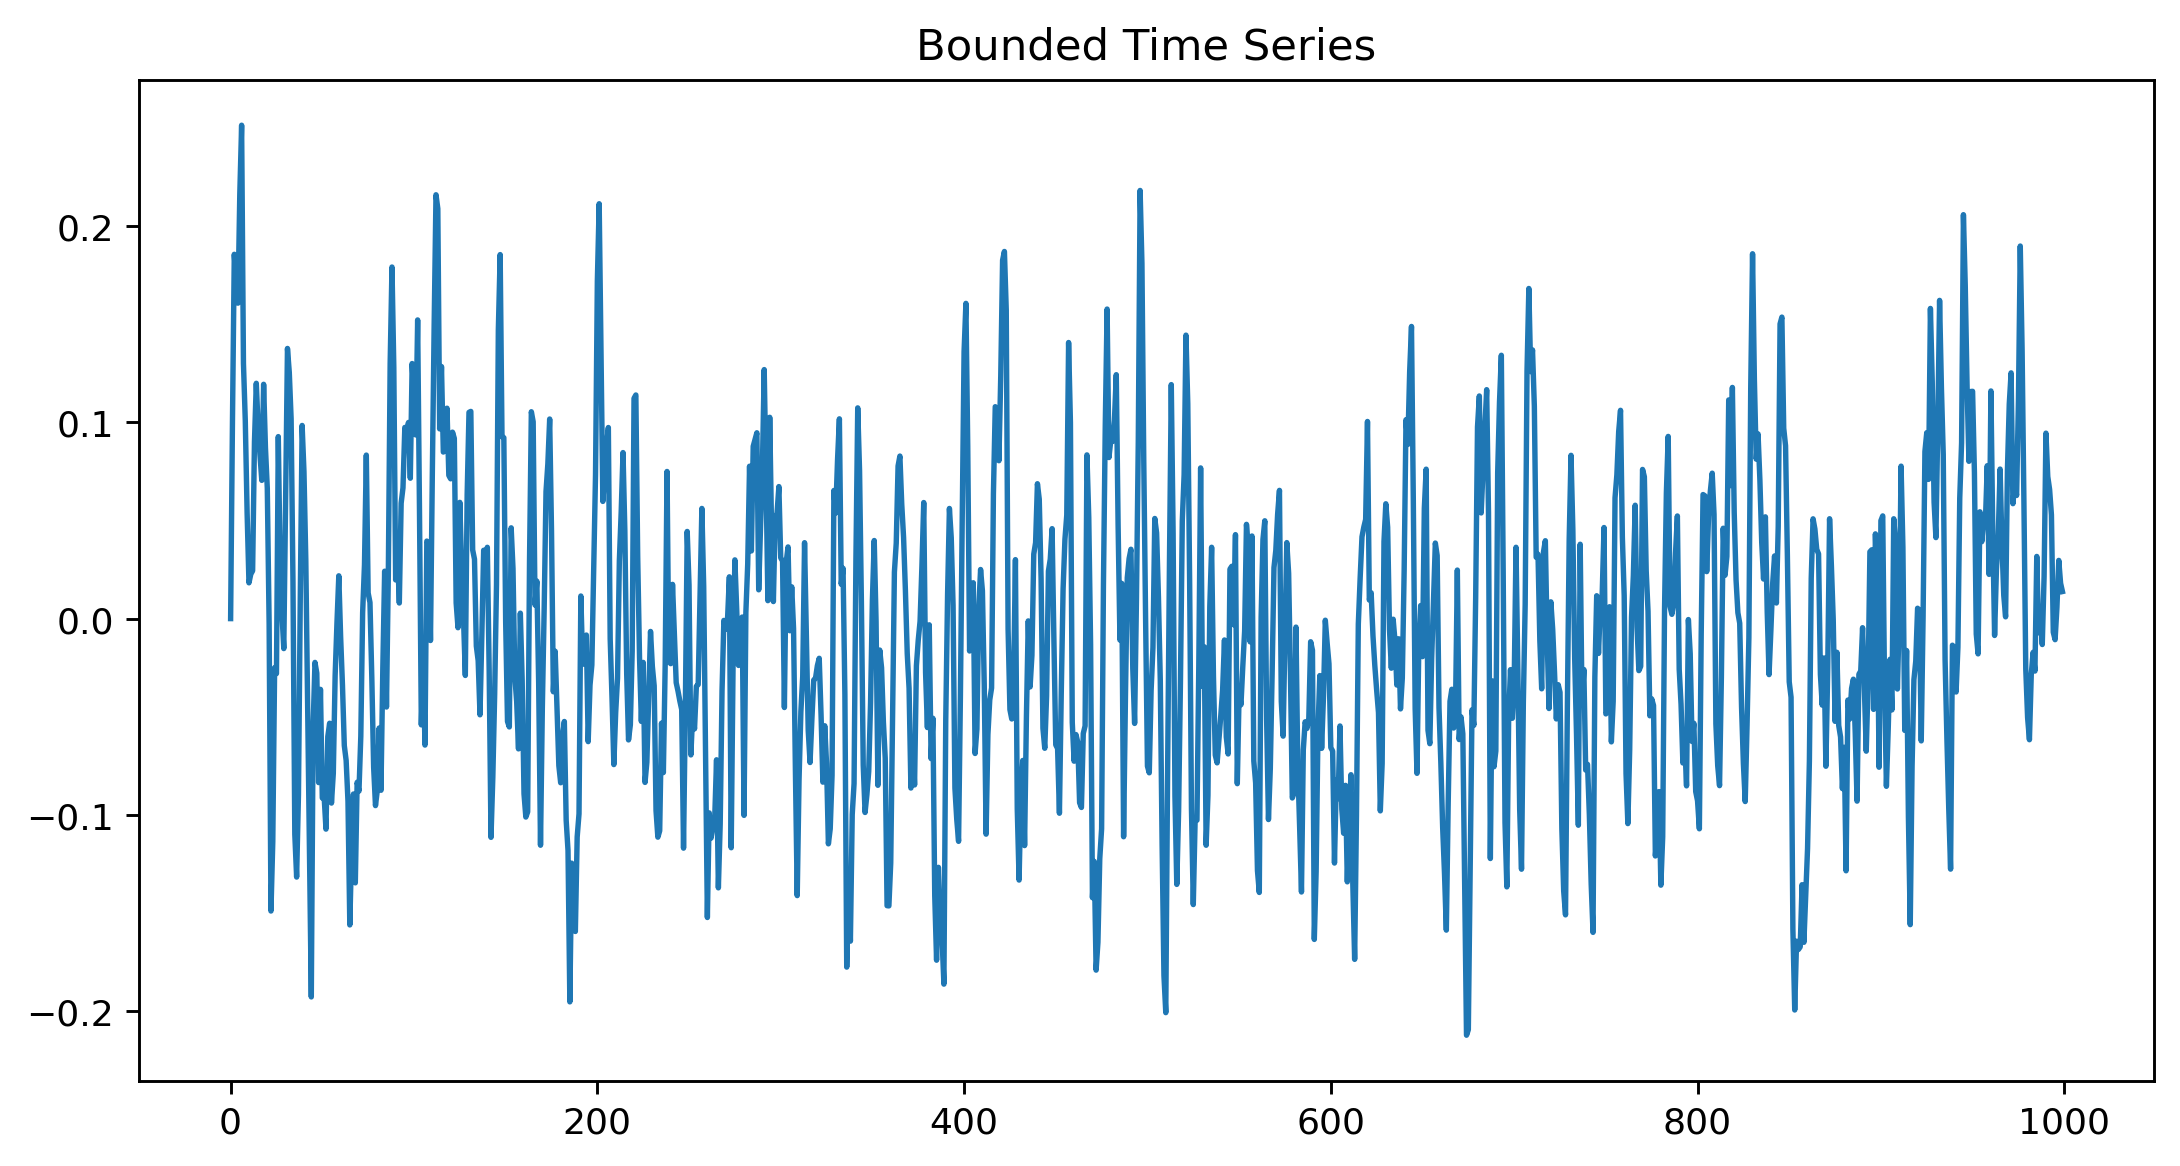

In [40]:
torch.manual_seed(0)
np.random.seed(0)
# ----- 1. Simulate bounded time series -----
# Nonlinear bounded series: x_t = 0.7*x_{t-1} - 0.3*x_{t-2} + 0.1*sin(3*x_{t-1}) + noise
T = 1000
x = np.zeros(T)
x[0], x[1] = 0.0, 0.1
for t in range(2, T):
    x[t] = 0.7 * x[t-1] - 0.3 * x[t-2] + 0.1 * np.sin(3 * x[t-1]) + 0.05 * np.random.randn()
    x[t] = np.tanh(x[t])  # keep within [-1, 1]

# plot this time series
plt.figure(figsize=(10,5))
plt.plot(x)
plt.title("Bounded Time Series")

# Create lagged time series dataframe and tensor

In [ ]:
# ----- 2. Prepare lagged features -----
def make_lagged(X, d):
    N = len(X) - d
    X_lag = np.zeros((N, d))
    y = np.zeros(N)
    for i in range(N):
        X_lag[i] = X[i:i+d][::-1]  # previous d timesteps (most recent first)
        y[i] = X[i+d]
    return X_lag, y

d = 4
X_lag, y = make_lagged(x, d)

# Split train/test
split = int(0.8 * len(y))
X_train, y_train = X_lag[:split], y[:split]
X_test, y_test = X_lag[split:], y[split:]

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)

# print out X_lag and y
print("X_lag:")
print(X_lag[:2])
print("y:")
print(y[:2])

X_lag:
[[0.52005581 0.44002661 0.05       0.        ]
 [0.05003522 0.52005581 0.44002661 0.05      ]]
y:
[ 0.05003522 -0.19780773]


# Define single-perceptron model

In [41]:
# ----- 3. Define single-perceptron model -----
class SinglePerceptron(nn.Module):
    def __init__(self, d, activation="tanh"):
        super().__init__()
        self.linear = nn.Linear(d, 1)
        acts = {
            "tanh": nn.Tanh(),
            "sigmoid": nn.Sigmoid(),
            "relu": nn.ReLU(),
            "identity": nn.Identity()
        }
        self.act = acts[activation]
    def forward(self, x):
        return self.act(self.linear(x))

model = SinglePerceptron(d=d, activation="tanh")

# Train and Evaluate on test set

Epoch 100: train_loss=0.1562, val_loss=0.1626
Epoch 200: train_loss=0.1549, val_loss=0.1653
Epoch 300: train_loss=0.1549, val_loss=0.1655
Epoch 400: train_loss=0.1549, val_loss=0.1655
Epoch 500: train_loss=0.1549, val_loss=0.1655


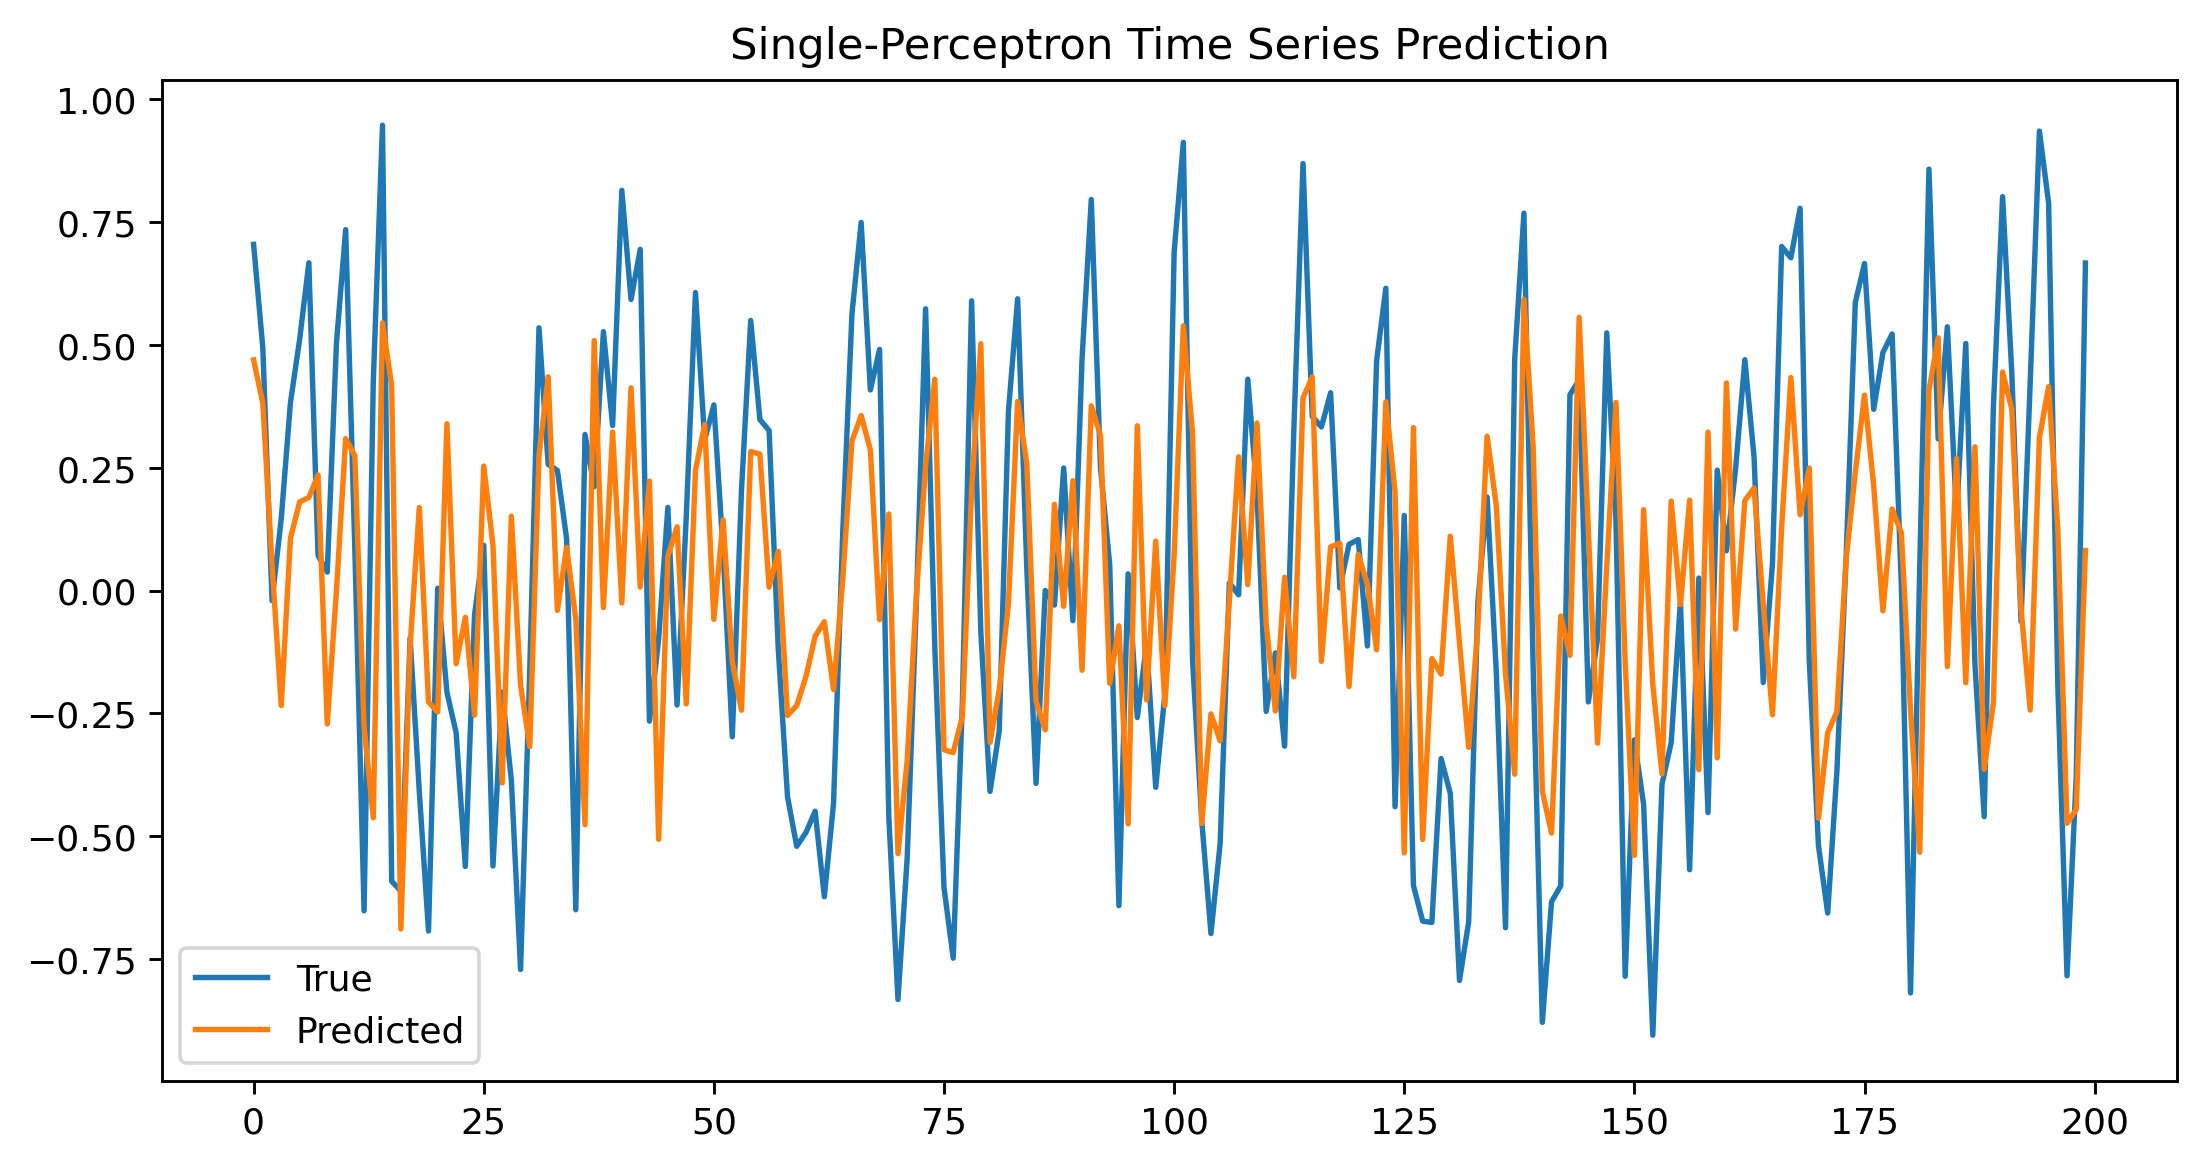

In [42]:
# ----- 4. Train -----
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01)

n_epochs = 500
for epoch in range(n_epochs):
    model.train()
    opt.zero_grad()
    pred = model(X_train_t)
    loss = loss_fn(pred, y_train_t)
    loss.backward()
    opt.step()

    if (epoch+1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_pred = model(X_test_t)
            val_loss = loss_fn(val_pred, y_test_t)
        print(f"Epoch {epoch+1}: train_loss={loss.item():.4f}, val_loss={val_loss.item():.4f}")

# ----- 5. Evaluate and visualize -----
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t).squeeze().numpy()

plt.figure(figsize=(10,5))
plt.plot(y_test, label="True")
plt.plot(y_pred, label="Predicted")
plt.title("Single-Perceptron Time Series Prediction")
plt.legend()
plt.show()